# GeoNet FDSN webservice with Obspy demo - Dataselect service

This tutorial demonstrates how to access the seismic waveforms from a seismic station. By the end of this notebook, the user will be able to generate a graph as shown below: <img src="day_plot.png" height="500" width="500">

This demo introduces a simple code that facilitates data requests using [GeoNet's FDSN webservices](http://www.geonet.org.nz/data/tools/FDSN) and [obspy module](https://github.com/obspy/obspy/wiki) in python. This notebook uses Python 3. 

### Getting Started - Import Modules

In [1]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client as FDSN_Client

### Define GeoNet FDSN client
Two webservice clients are defined below.
 - The archive client: this service is as complete as possible, but 7 days behind the present time.
 - The near real-time client: this service is as fast as possible but may not be complete. It contains the most recent waveform data covering the last 8 days of available waveforms.

In [2]:
client = FDSN_Client("GEONET")
client_nrt = FDSN_Client("https://service-nrt.geonet.org.nz")

## Accessing waveforms
The FDSN-**dataselect** service provides access to waveforms at the seismic station, channel and time range of interest.

Data is returned as a stream object, made up of a number of traces. 

Data requests can be filtered by time, station, channel, etc. UNIX wildcards can also be used in the request.

The example below demostrates how the waveforms for the 2016 Kaikoura earthquake recorded at THZ near Nelson Lakes are retrieved and plotted. This station is equipped with a seismometer (channel code ending in HH* ) and an accelerometer (channel code ending in HN* ). 

In [3]:
t = UTCDateTime("2016-11-13T11:02:30.000")
st = client.get_waveforms("NZ", "THZ","*", "H??", t, t + 300,attach_response=True)
print(st)

6 Trace(s) in Stream:
NZ.THZ.10.HHE | 2016-11-13T11:02:25.473189Z - 2016-11-13T11:07:31.073189Z | 100.0 Hz, 30561 samples
NZ.THZ.10.HHN | 2016-11-13T11:02:29.263189Z - 2016-11-13T11:07:30.483189Z | 100.0 Hz, 30123 samples
NZ.THZ.10.HHZ | 2016-11-13T11:02:23.953190Z - 2016-11-13T11:07:31.293190Z | 100.0 Hz, 30735 samples
NZ.THZ.20.HNE | 2016-11-13T11:02:29.690000Z - 2016-11-13T11:07:30.925000Z | 200.0 Hz, 60248 samples
NZ.THZ.20.HNN | 2016-11-13T11:02:29.770000Z - 2016-11-13T11:07:30.145000Z | 200.0 Hz, 60076 samples
NZ.THZ.20.HNZ | 2016-11-13T11:02:29.580000Z - 2016-11-13T11:07:30.170000Z | 200.0 Hz, 60119 samples


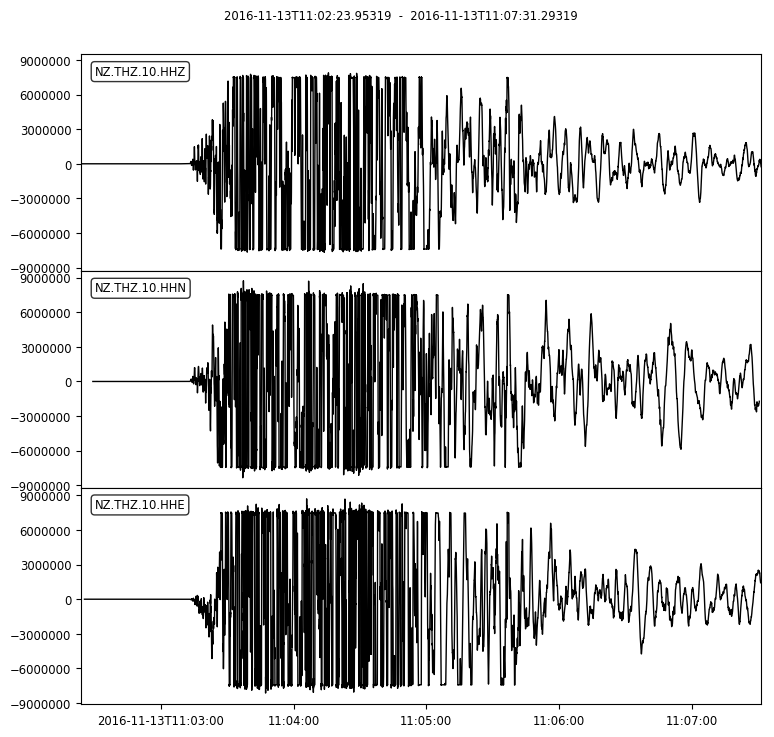

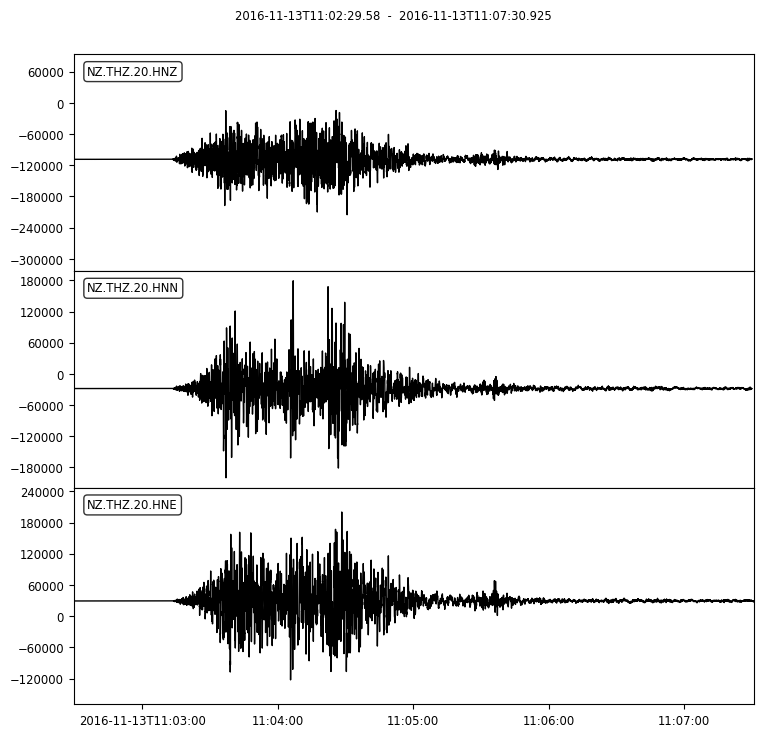

In [5]:
st[0:3].plot()
st[3:6].plot()

Note in the original request to get the waveforms, "attach_response" is set to True. This is useful in the analysis to account for the instrument repsonse.

The example below removes the instrument response from the acceleration records. The peak ground accelerations are estimated for each channel orientation.

In [6]:
pre_filt = (0.025, 0.03, 70.0, 80.0)
acc = st[3:6]
acc.remove_response(output='ACC', pre_filt=pre_filt)
pga = acc.max()
print('PGA (HNE) = %f, PGA (HNN) = %f, PGA (HNZ) = %f m/s/s ' % (pga[0],pga[1],pga[2]))

PGA (HNE) = 0.402338, PGA (HNN) = 0.485368, PGA (HNZ) = -0.249306 m/s/s 


Another common request is to view an entire day worth of data at a site.

This example is from a volcanic swarm at Mt Ruapehu.

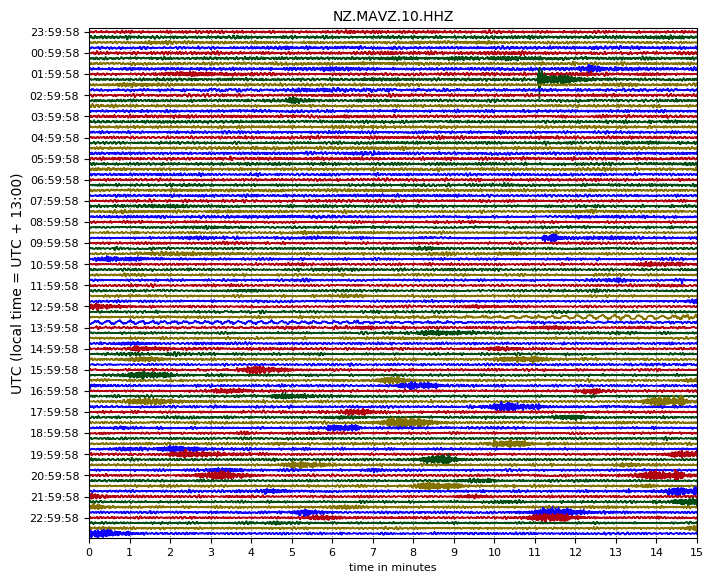

In [6]:
t = UTCDateTime("2016-04-27T00:00:00.000")
st = client.get_waveforms("NZ", "MAVZ","10", "HHZ", t, t + 86400)
st.plot(type="dayplot")

The next steps show how to generate spectrogram plots.

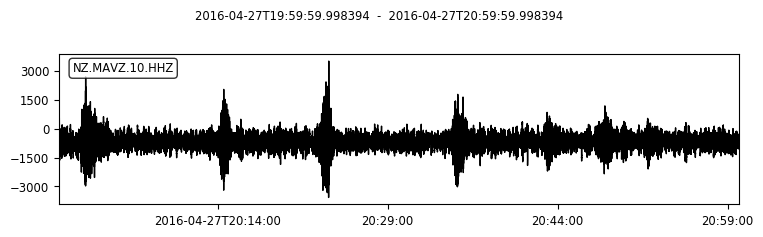

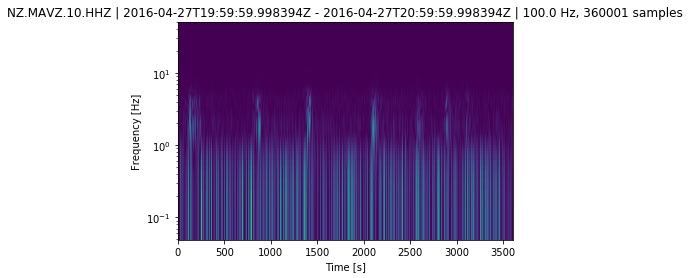

[None]

In [7]:
t = UTCDateTime("2016-04-27T20:00:00.000")
st.trim(t,t+3600)
st.plot()
st.spectrogram(log=True)

At the beginning of this workbook, two webservice clients were defined: the archive service and the near real-time service. 
The following example demostrates accessing the data from the near real-time webservice. The access to the last day of data recorded at a seismic station (KHZ), for the HHZ channel is shown:

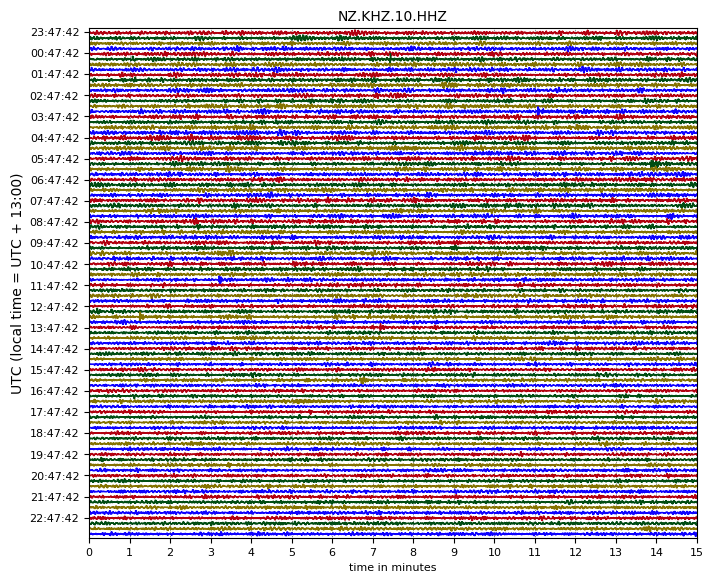

In [8]:
t = UTCDateTime.now()
st = client_nrt.get_waveforms("NZ", "KHZ", "10", "HHZ",t-86400,t)
st.plot(type="dayplot")

Available metadata pertaining to basic attributes that describe the data can also be checked. These are the metadata contained in the header of the miniseed.

In [10]:
print(st[0].stats)

               network: NZ
               station: KHZ
              location: 10
               channel: HHZ
             starttime: 2018-12-06T00:23:22.848394Z
               endtime: 2018-12-07T00:23:16.688394Z
         sampling_rate: 100.0
                 delta: 0.01
                  npts: 8639385
                 calib: 1.0
_fdsnws_dataselect_url: https://service-nrt.geonet.org.nz/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({u'record_length': 512, u'encoding': u'STEIM2', 'filesize': 11620352, u'dataquality': u'D', u'number_of_records': 22696L, u'byteorder': u'>'})


The service will return more data than the requested time window. After trimming the data, the completeness can be checked using the following steps: 

In [9]:
st[0].trim(t-86400,t)
completeness = (st[0].stats.npts)/(st[0].stats.sampling_rate*86400)*100
print(st[0].stats.npts)
print('%f percent complete in the last day at %s' % (completeness, st[0].stats.station))

8639701
99.996539 percent complete in the last day at KHZ
